In [91]:
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
import chess
import pandas as pd
import utils.chess_utils as chess_utils
import numpy as np
import matplotlib.pyplot as plt
from utils.pikeBot_chess_utils import Pikebot, PikeBotModelWrapper
from evaluation_utils import set_engine_history

In [2]:
import zstandard as zstd

input_file = 'data/lichess_db_puzzle.csv.zst'
output_file = 'data/lichess_db_puzzle.csv'

In [ ]:
with open(input_file, 'rb') as compressed_file:
    with open(output_file, 'wb') as decompressed_file:
        dctx = zstd.ZstdDecompressor()
        dctx.copy_stream(compressed_file, decompressed_file)

print("File decompressed successfully!")

In [86]:
df = pd.read_csv(output_file)
df = df[:1000]
df.head(2)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1996,75,95,6860,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1574,73,96,28960,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN


In [87]:
df["Board"] = df["FEN"].apply(chess.Board)
df.head(2)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,Board
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1996,75,95,6860,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN,r . . . . . . k\np p . . r . . p\n. . . . R p ...
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1574,73,96,28960,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN,. . . . . r k .\n. p . . . p p p\np q . . . b ...


In [6]:
stockfish_path = "D:/Program Files/Stockfish/stockfish/stockfish-windows-x86-64-avx2.exe"
model_path = "../Models/PikeBot_Models/small_500k/PikeBotSmall500k.pth"
preprocessing_parameters_path = "../model_loading_data/preprocessing_parameters.json"


model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
engine = Pikebot( model=model, 
                        aggregate=chess_utils.mean_aggr,
                        stockfish_path=stockfish_path,
                        color=chess.WHITE,
                        opponents_elo = 800
                        )

In [88]:

def test_games(index, color):    
    games = df[index]
    engine.color = color
    for elo in [800, 1100, 1400, 1700, 2000, 2300, 2600]:
        engine.opponents_elo = elo
        predictions = list()
        for game in games.itertuples():
            game_predictions = list()
            board: chess.Board = game.Board.copy()
            board_history = [board]
            set_engine_history(engine, board_history)  
            for i, move in enumerate(game.Moves.split()):
                if i % 2 == 1:
                    encoded_states = list()
                    legal_moves = list(board.legal_moves)
                    for next_move in legal_moves:
                        board.push(next_move)
                        score = engine.get_board_score(board)
                        engine.move_history.append(board.copy())
                        engine.evaluation_history.append(score)

                        encoded_state = model.encode(engine.move_history, engine.evaluation_history, engine.get_additional_attributes())
                        encoded_states.append(encoded_state)

                        engine.evaluation_history.pop()
                        engine.move_history.pop()
                        board.pop()
                    choice_probs = engine.model.predict_batch(encoded_states).reshape(-1)
                    legal_moves_uci = [move.uci() for move in legal_moves]
                    move_index = legal_moves_uci.index(move)
                    probability_order = np.argsort(choice_probs)
                    move_position = np.where(probability_order==move_index)

                    game_predictions.append(move_position)

                board.push_uci(move)
                score = engine.get_board_score(board)
                engine.move_history.append(board.copy())
                engine.evaluation_history.append(score)
            predictions.append(np.median(game_predictions))
        if str(elo) not in df.columns:
            df[str(elo)] = None
        df.loc[index, str(elo)] = predictions

white_index = df.Board.apply(lambda x: x.turn) 
black_index = df.Board.apply(lambda x: not x.turn) 

test_games(white_index, chess.BLACK)
test_games(black_index, chess.WHITE)



In [90]:
df[["PuzzleId", "Rating", "800", "1100", "1400", "1700", "2000", "2300"]].to_csv("results/puzzle_prediction.csv", index=False)

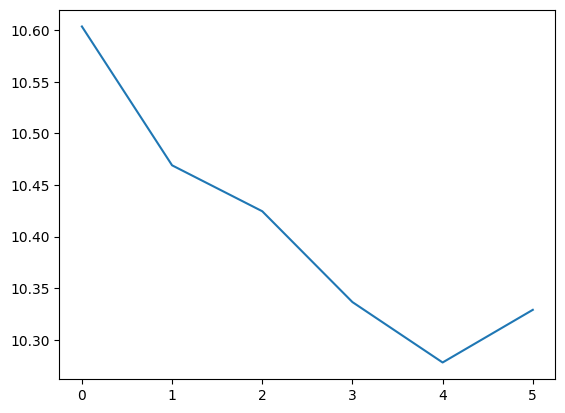

In [107]:
prediction_scores = df[["800", "1100", "1400", "1700", "2000", "2300"]].to_numpy()
plt.plot(np.average(prediction_scores, axis=0))

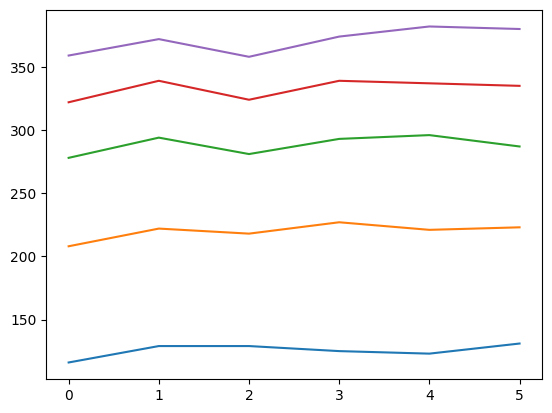

In [115]:
for i in range(5):
    plt.plot(np.sum(prediction_scores <= i, axis=0))

In [130]:
from scipy.stats import pearsonr

flatten_scores = prediction_scores.reshape(-1).astype(np.int32)

correlation, p_value = pearsonr(flatten_scores, [800, 1100, 1400, 1700, 2000, 2300]*1000)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: -0.0098167264685705
P-value: 0.44709903860966527


In [148]:
for i in range(10):
    low_rated_index = np.any(prediction_scores <= i, axis=1)
    flatten_low_scores = prediction_scores[low_rated_index].astype(np.int32)

    correlation, p_value = pearsonr(flatten_low_scores.reshape(-1), [800, 1100, 1400, 1700, 2000, 2300]*flatten_low_scores.shape[0])

    print(f"Pearson correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")
    print()


Pearson correlation coefficient: -0.016784940592955065
P-value: 0.5912504742800362

Pearson correlation coefficient: -0.029573155280214435
P-value: 0.2282094611464778

Pearson correlation coefficient: -0.04583961816423092
P-value: 0.037031813837658877

Pearson correlation coefficient: -0.02523683795479702
P-value: 0.2229314267752881

Pearson correlation coefficient: -0.028658332175571226
P-value: 0.14513045456881205

Pearson correlation coefficient: -0.03265573101853256
P-value: 0.08197103823450141

Pearson correlation coefficient: -0.034417428053187746
P-value: 0.058184962751153015

Pearson correlation coefficient: -0.0380929516986977
P-value: 0.030602522656067808

Pearson correlation coefficient: -0.028928724726121145
P-value: 0.09017474339224368

Pearson correlation coefficient: -0.026597588876110984
P-value: 0.10969397846124312

